In [1]:
import pandas as pd
import json
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import pickle
from DataLoader import MolDataset
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch.optim import AdamW
import numpy as np
from scipy.spatial import distance
from PyPDF2 import PdfReader, PdfWriter, PdfMerger
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
import matplotlib

font = {
        'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)


In [2]:
from Dual_channel_gin_extend_expl import GNNModel

In [3]:
'''
Change result dict when you run new experiments 
    
    
    "folder":49,"seed":1,"layer_type":["GINConv", "GCNConv", "GATConv"],"channel":["Vanilla", "SingleChannel", "DualParam"]},
    {"dataset":"hERG","folder":49,"seed":3,"layer_type":["GINConv", "GCNConv", "GATConv"],"channel":["Vanilla", "SingleChannel", "DualParam"]},
    {"dataset":"hERG","folder":48,"seed":0,"layer_type":["GINConv", "GCNConv", "GATConv"],"channel":["Vanilla", "SingleChannel", "DualParam"]},
    {"dataset":"hERG","folder":48,"seed":2,"layer_type":["GINConv", "GCNConv", "GATConv"],"channel":["Vanilla", "SingleChannel", "DualParam"]},
    {"dataset":"MUTAG","folder":47,"seed":1,"layer_type":["GINConv", "GCNConv", "GATConv"],"channel":["Vanilla", "SingleChannel", "DualParam"]},
    {"dataset":"MUTAG","folder":47,"seed":3,"layer_type":["GINConv", "GCNConv", "GATConv"],"channel":["Vanilla", "SingleChannel", "DualParam"]},
    {"dataset":"MUTAG","folder":46,"seed":0,"layer_type":["GINConv", "GCNConv", "GATConv"],"channel":["Vanilla", "SingleChannel", "DualParam"]},
    {"dataset":"MUTAG","folder":46,"seed":2,"layer_type":["GINConv", "GCNConv", "GATConv"],"channel":["Vanilla", "SingleChannel", "DualParam"]},
    {"dataset":"BBBP","folder":47,"seed":1,"layer_type":["GINConv", "GCNConv", "GATConv"],"channel":["Vanilla", "SingleChannel", "DualParam"]},
    {"dataset":"BBBP","folder":47,"seed":3,"layer_type":["GINConv", "GCNConv", "GATConv"],"channel":["Vanilla", "SingleChannel", "DualParam"]},
    {"dataset":"BBBP","folder":46,"seed":0,"layer_type":["GINConv", "GCNConv", "GATConv"],"channel":["Vanilla", "SingleChannel", "DualParam"]},
    {"dataset":"BBBP","folder":46,"seed":2,"layer_type":["GINConv", "GCNConv", "GATConv"],"channel":["Vanilla", "SingleChannel", "DualParam"]}]
    


**IMPORTANT** : Change EXPT_BASE_NAME if you update the folder name to where your results are stored
'''

date_tag = '0830'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


expt_dict = [
    
    {"dataset":"HERG", "seed_info" : {1:49,3:49,0:48,2:48}},
    {"dataset":"MUTAG", "seed_info" : {1:47,3:47,0:46,2:46}},
    {"dataset":"BBBP", "seed_info" : {1:47,3:47,0:46,2:46}}]

dataset_dict = {'BBBP':'BBBP','MUTAG':'Mutagenicity','HERG':'hERG'}

def return_expt_base_name(seed,layer_type,channel,folder,dataset):

    BASE_PATH = f'../Cluster_JOBS/LoG_plot/{folder}/EXPT-32A{dataset}-{seed}-{layer_type}-{channel}'
    return BASE_PATH



In [4]:
def return_quadrant_of_motif(x,y):
    
    if x>0.5 and y>0.5:
        return 1
    if x<0.5 and y>0.5:
        return 2
    if x<0.5 and y<0.5:
        return 3
    if x>0.5 and y<0.5:
        return 4

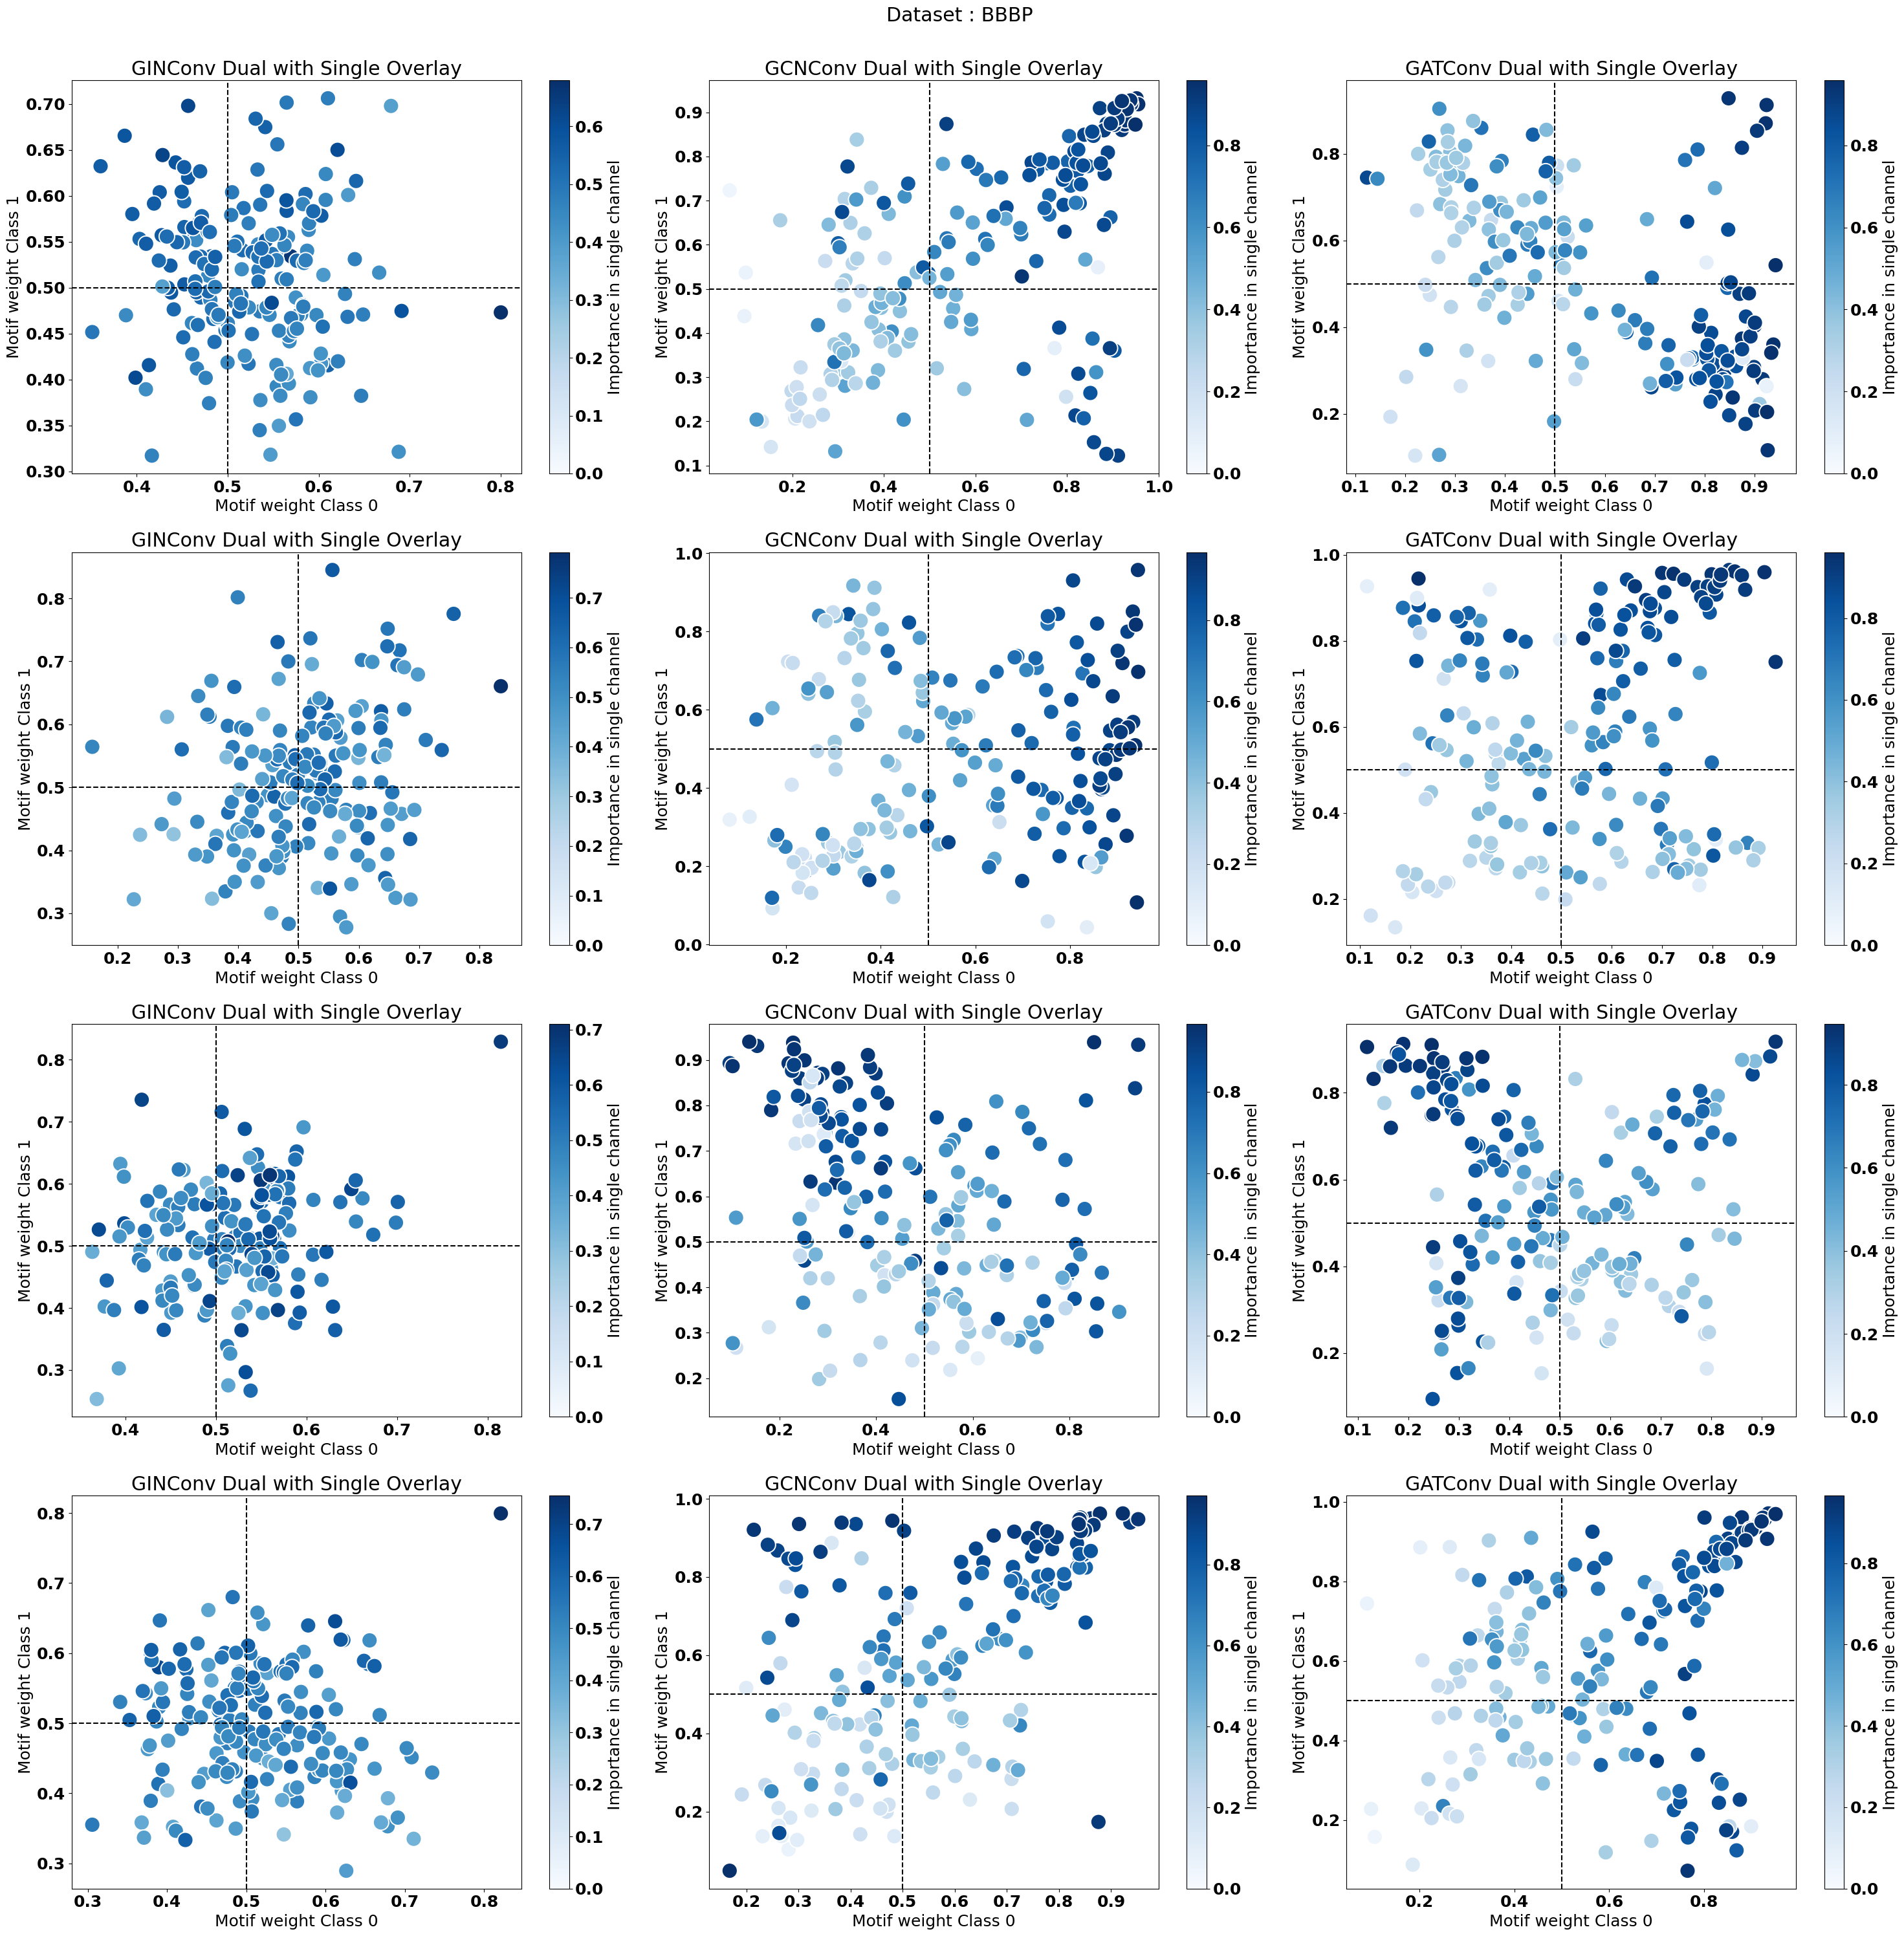

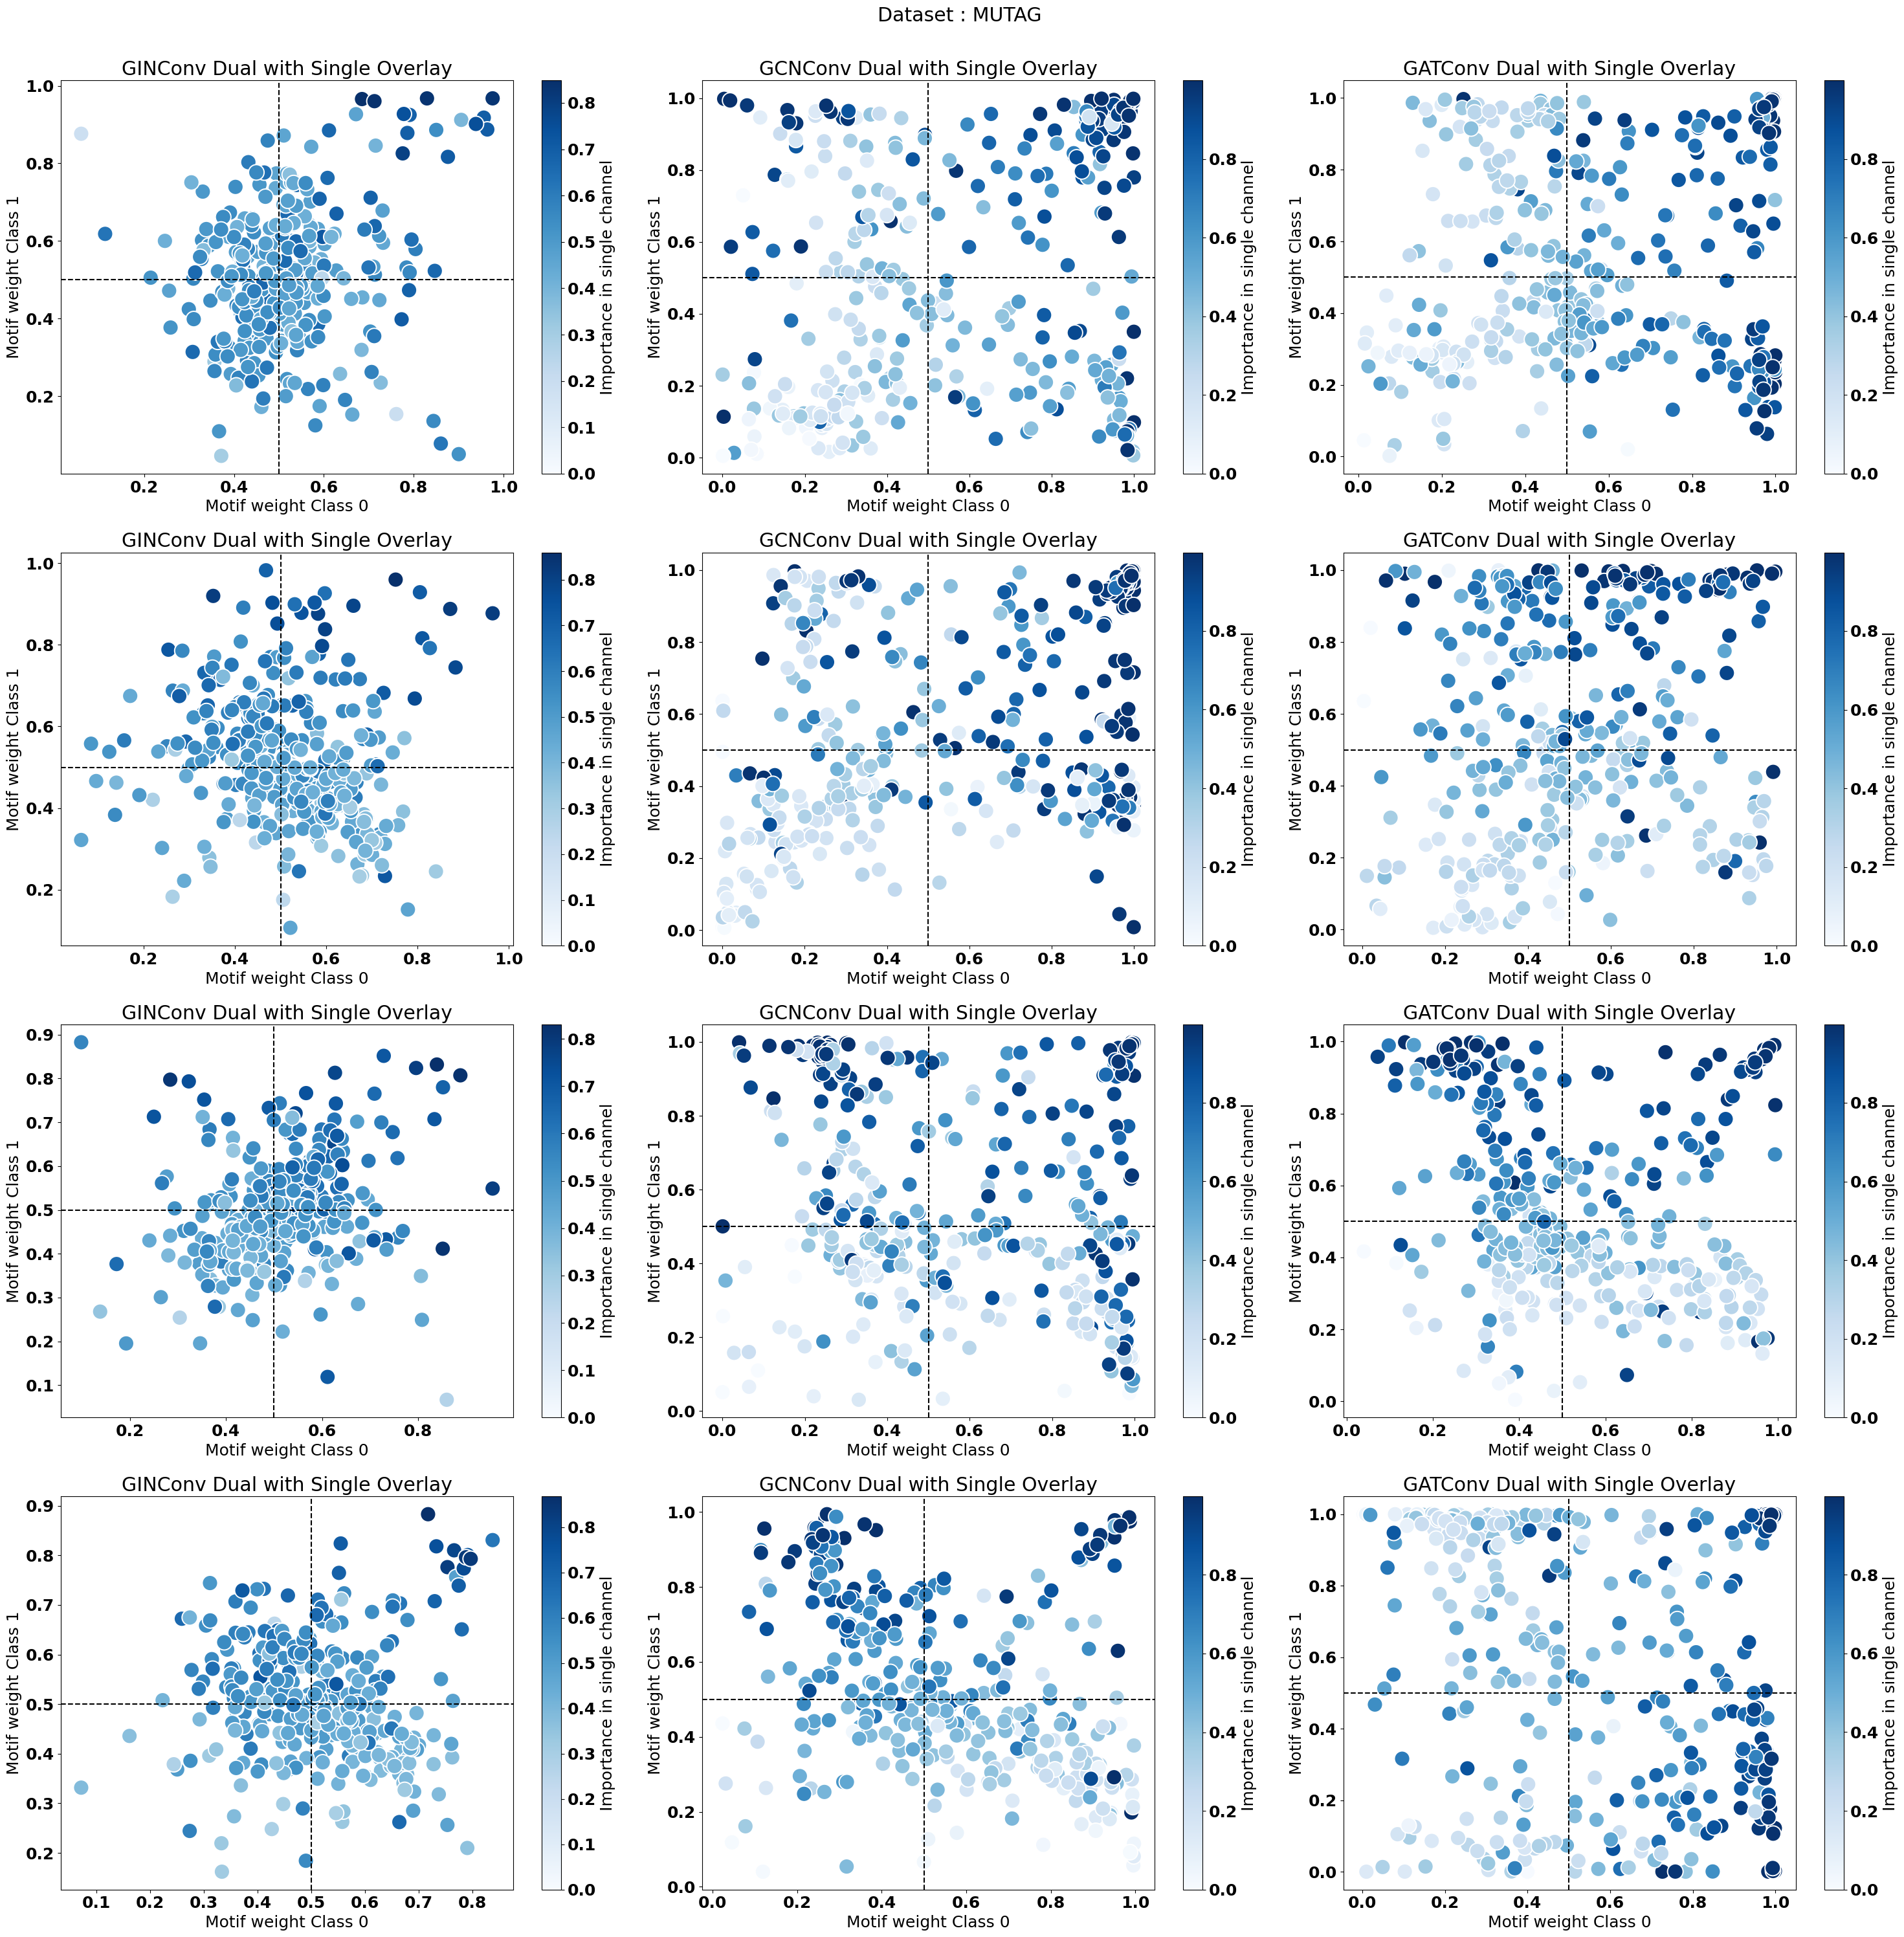

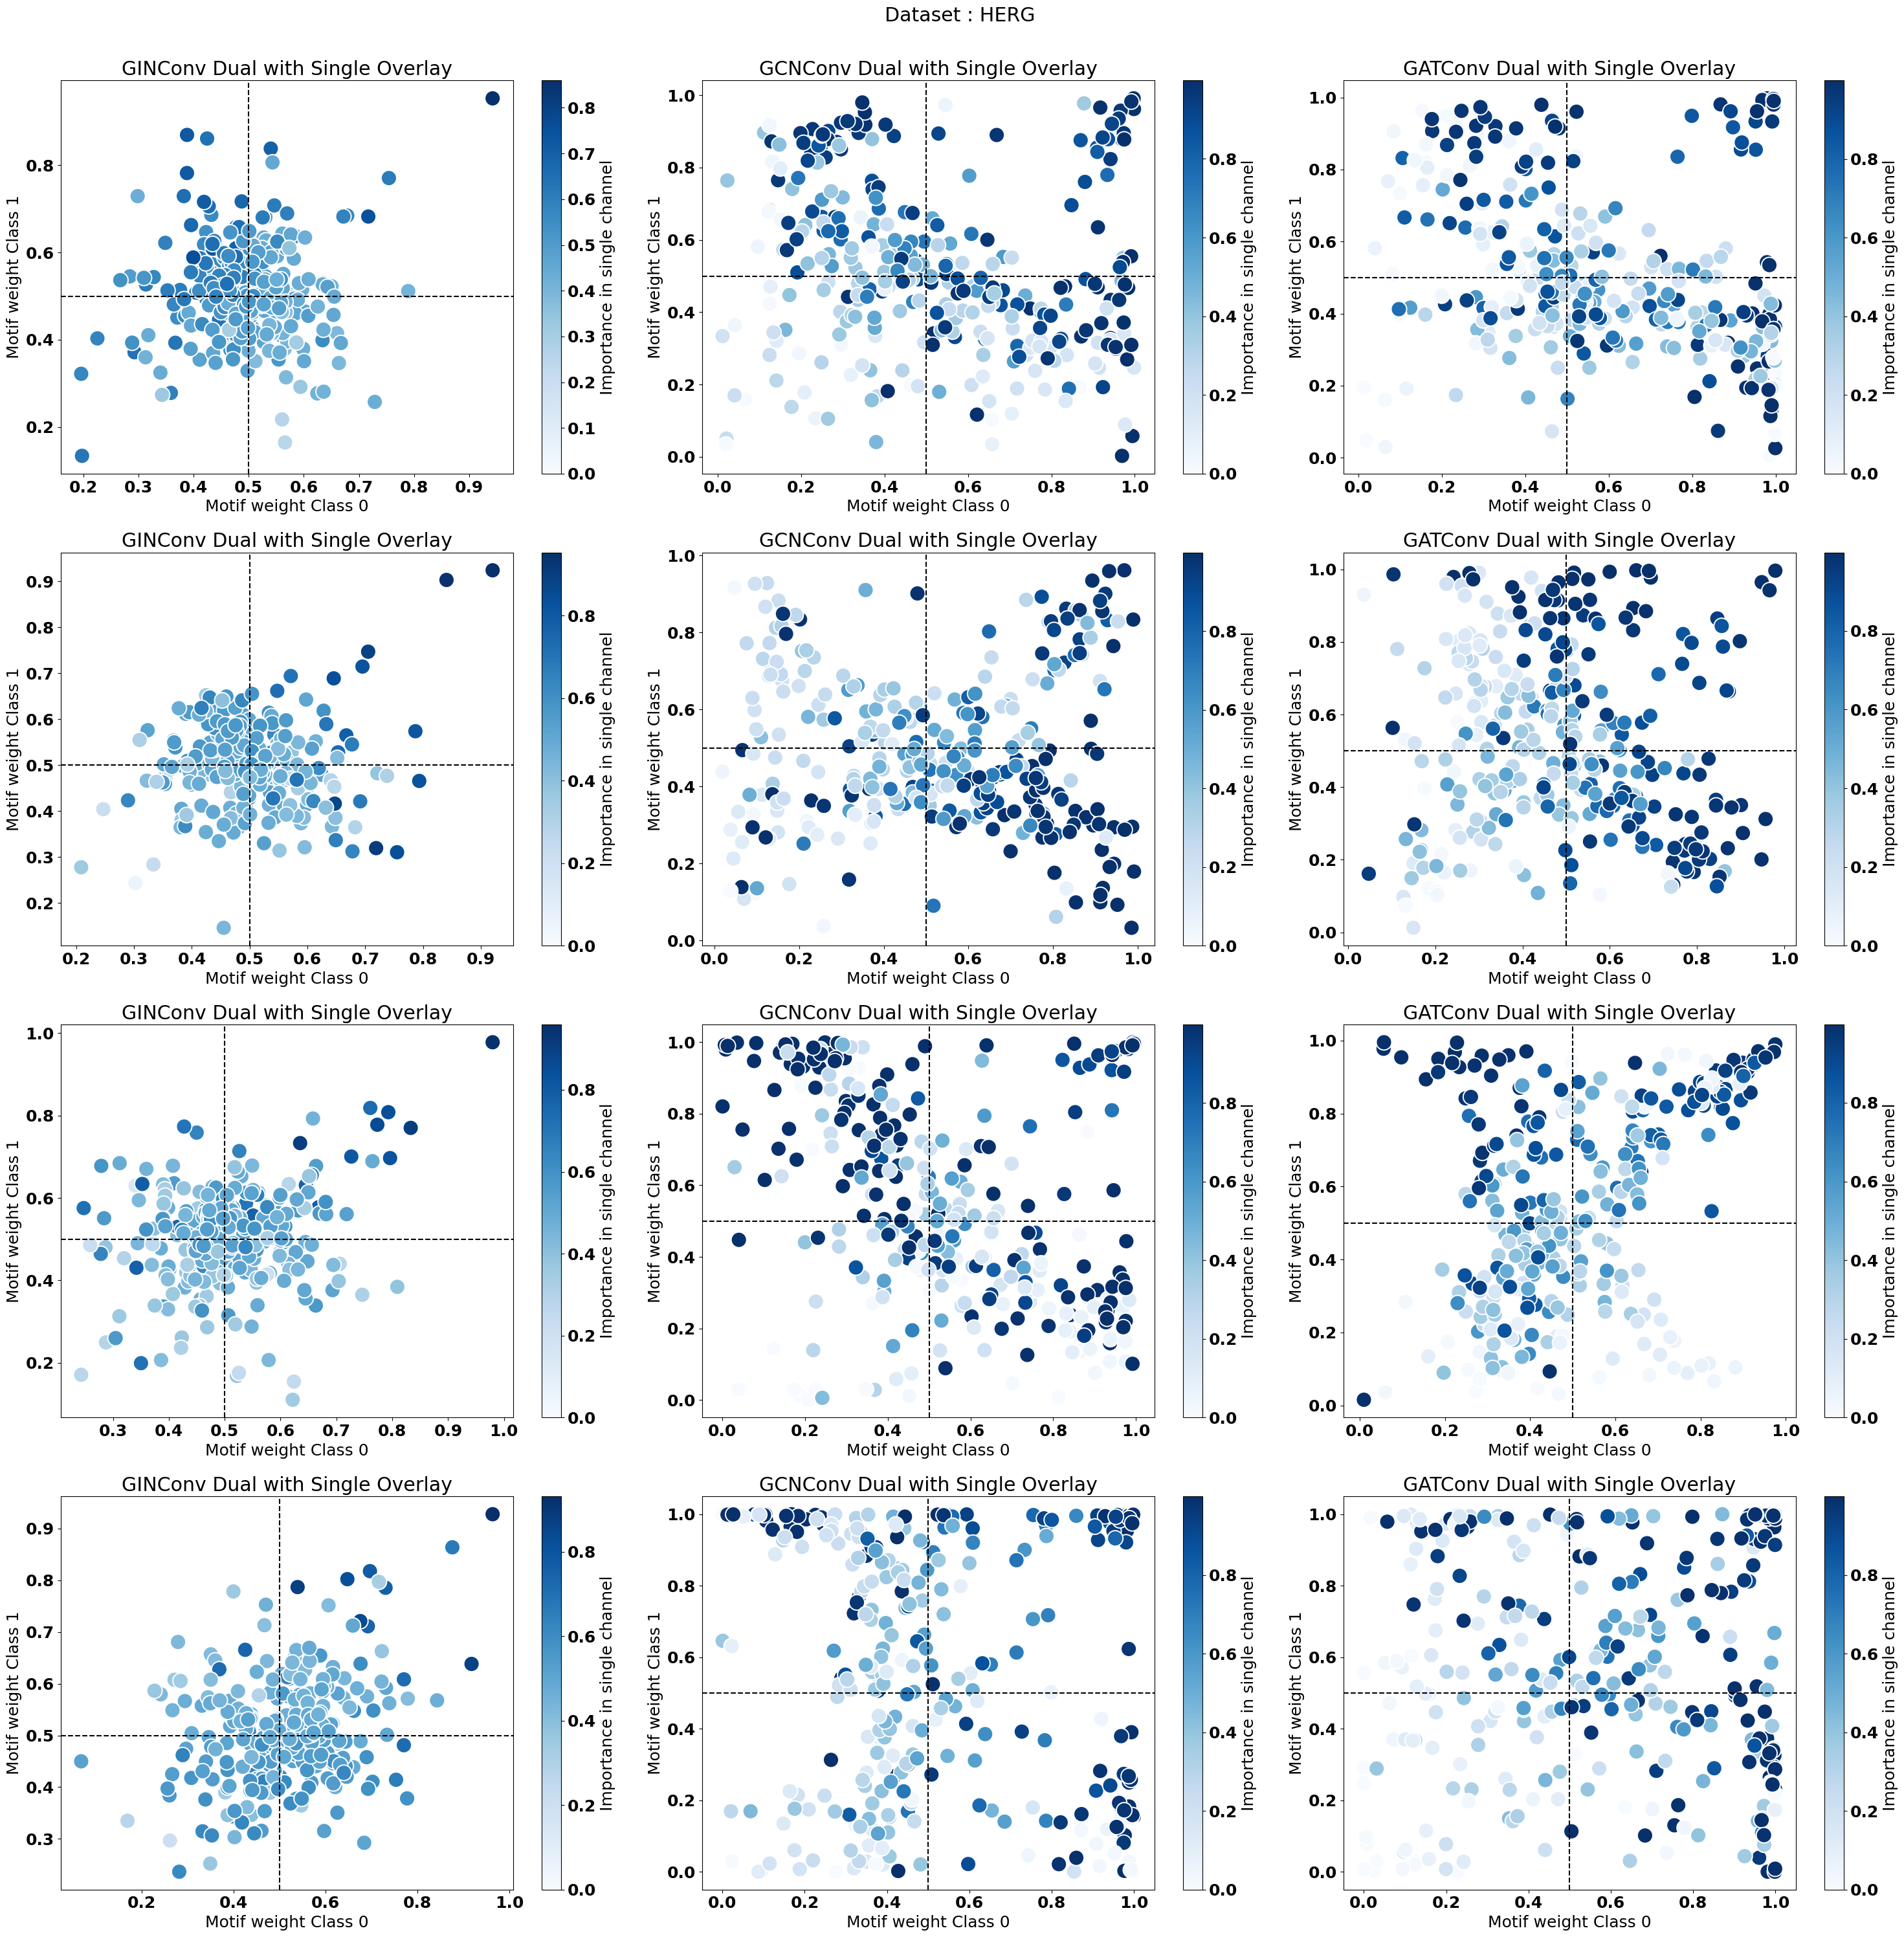

In [15]:
import matplotlib.colors as mcolors
for dataset in dataset_dict.keys():
    training_data = MolDataset(root=".", split='training',csv_file=f"{dataset_dict[dataset]}.csv")
    with open(f'./dictionary/{dataset_dict[dataset]}_graph_lookup_{date_tag}.pickle', 'rb') as file:
        lookup = pickle.load(file)
    with open(f'dictionary/{dataset_dict[dataset]}_motif_list_{date_tag}.pickle', 'rb') as file:
        motif_list = list(pickle.load(file))
    with open(f'dictionary/{dataset_dict[dataset]}_test_graph_lookup_{date_tag}.pickle', 'rb') as file:
        # Serialize and save the object to the file
        test_data_lookup = pickle.load(file)
    
    
    #for layer_type in ["GATConv"]:
    fig, axes = plt.subplots(4, 3, figsize=(30,30))
    for l_i,layer_type in enumerate(["GINConv", "GCNConv", "GATConv"]):
        for seed in [0, 1, 2, 3]:

            found = False

            for folder_dict in expt_dict:
                if folder_dict['dataset'] == dataset:
                    folder = folder_dict['seed_info'][seed]

            EXPT_PATH_DP = return_expt_base_name(seed,layer_type,"DualParam",folder,dataset)
            EXPT_PATH_SC = return_expt_base_name(seed,layer_type,"SingleChannel",folder,dataset)

            try:
                #Recreate loss metrics
                logit_val = pd.read_csv(EXPT_PATH_DP+f'/{dataset_dict[dataset]}_explanation_result_with_validation.csv')
                logit_test = pd.read_csv(EXPT_PATH_DP+f'/{dataset_dict[dataset]}_explanation_result_with_test.csv')
                logit_combined_DP = pd.concat([logit_val,logit_test], axis = 0)
                
                logit_val = pd.read_csv(EXPT_PATH_SC+f'/{dataset_dict[dataset]}_explanation_result_with_validation.csv')
                logit_test = pd.read_csv(EXPT_PATH_SC+f'/{dataset_dict[dataset]}_explanation_result_with_test.csv')
                logit_combined_SC = pd.concat([logit_val,logit_test], axis = 0)
                        
            except Exception as e:
                print(f"error when trying to validation motif logit differences: {e}")
                found = False
                    
                    
            logit_combined_SC['logit_diff_class_0'] = logit_combined_SC['new_logit_class_0'] - logit_combined_SC['original_logit_class_0']
            logit_combined_SC['logit_diff_class_1'] = logit_combined_SC['new_logit_class_1'] - logit_combined_SC['original_logit_class_1']
            logit_combined_SC['logit_diff'] = logit_combined_SC['logit_diff_class_0'] - logit_combined_SC['logit_diff_class_1']
            # logit_combined_SC = logit_combined_SC.groupby('motif_id').agg(
            #                                     mean_logit_diff         = ('logit_diff', 'mean'),
            #                                     num_motifs_in_graph    =('motif_id', 'count')).reset_index()
            logit_combined_SC = logit_combined_SC.groupby('motif_id').agg(
                                                mean_sigmoid_importance_single=('sigmoid_importance_for_class_0', 'mean'),
                                                num_motifs_in_graph    =('motif_id', 'count')).reset_index()
            
            # input(logit_combined_SC)
            
            logit_combined_DP = logit_combined_DP.groupby('motif_id').agg(
                                                mean_sigmoid_importance_class_1=('sigmoid_importance_for_class_1', 'mean'),
                                                mean_sigmoid_importance_class_0=('sigmoid_importance_for_class_0', 'mean')).reset_index()
            
            
            logit_combined_SC = logit_combined_SC.merge(logit_combined_DP, on = 'motif_id', how = 'inner')

            # Function to plot data
            def plot_data(ax, title, legend):
                # Define hue limits to center around 0
                # vmin, vmax = -max(abs(logit_combined_SC["mean_logit_diff"].min()), abs(logit_combined_SC["mean_logit_diff"].max())), max(abs(logit_combined_SC["mean_logit_diff"].min()), abs(logit_combined_SC["mean_logit_diff"].max()))
                vmin, vmax = 0, max(abs(logit_combined_SC["mean_sigmoid_importance_single"].min()), abs(logit_combined_SC["mean_sigmoid_importance_single"].max()))

                # sns.scatterplot(data=logit_combined_SC, x='mean_sigmoid_importance_class_0', y='mean_sigmoid_importance_class_1', hue="mean_logit_diff", palette='coolwarm', 
                #                 hue_norm=mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax),  ax=ax, legend=True,alpha=1,s=300)
                sc = sns.scatterplot(data=logit_combined_SC, x='mean_sigmoid_importance_class_0', y='mean_sigmoid_importance_class_1', hue="mean_sigmoid_importance_single", palette='Blues', 
                                hue_norm=mcolors.Normalize(vmin=vmin,vmax=vmax),  ax=ax, legend=False,alpha=1,s=300)

                # Adding horizontal and vertical lines at 0.5
                ax.axhline(0.5, color='black', linestyle='--')
                ax.axvline(0.5, color='black', linestyle='--')

                ax.set_title(f'{title}')  # Optional title for the seaborn plot
                ax.set_xlabel('Motif weight Class 0')  # Optional title for the seaborn plot
                ax.set_ylabel('Motif weight Class 1')  # Optional title for the seaborn plot
                # ax.legend(title=f'{legend}', loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
                norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
                sm = plt.cm.ScalarMappable(cmap='Blues', norm=norm)
                sm.set_array([])

                cbar = plt.colorbar(sm, ax=ax)
                cbar.set_label('Importance in single channel')
                #ax.grid(True)

                #param_numpy = logit_val[['mean_sigmoid_importance_class_0', 'mean_sigmoid_importance_class_1']].to_numpy()
                
                '''

                logit_combined_SC['mean_logit_diff_2'] = logit_combined_SC.apply(lambda x : abs(x['mean_logit_diff']),axis = 1)
                top_10_hues = logit_combined_SC.sort_values(by='mean_logit_diff_2', ascending=False).head(5)

                #print(top_10_hues)
                top_10_hues['motif_string'] = top_10_hues.apply(lambda x : motif_list[int(x['motif_id'])], axis = 1)


                
                #ax.annotate(motif_list[i], (top_10_hues[i, 0], param_numpy[i, 1]), textcoords="offset points", xytext=(5, 5+ y_offset), ha='center',fontsize=6)
                #print(top_10_hues.loc[top_10_hues['motif_id'] == i, 'mean_sigmoid_importance_class_0'])
                for i in top_10_hues.motif_id.tolist():
                    y_offset = np.random.uniform(-5, 5)
                    ax.annotate(motif_list[i], (top_10_hues.loc[top_10_hues['motif_id'] == i, 'mean_sigmoid_importance_class_0'],top_10_hues.loc[top_10_hues['motif_id'] == i, 'mean_sigmoid_importance_class_1']), textcoords="offset points", xytext=(5, 5+ y_offset), ha='center',bbox = dict(boxstyle="round", fc="0.8"), fontsize = 15)
                '''


            # Plot for hue_col_1
            plot_data(axes[seed,l_i],f'{layer_type} Dual with Single Overlay', 'Scale')

            # # Plot for hue_col_2
            # plot_data(axes[seed,3], 'mean_logit_diff_class_1',f'Mean Logit Difference Class 1 - Seed {seed}', 'Scale Class 1')


    plt.suptitle(f'Dataset : {dataset}', y=1,)

    plt.tight_layout()
    #plt.show()

    plt.savefig(f'plots_8/{dataset}.png')
                    


             

In [6]:
logit_val['logit_diff_class_0'] = logit_val['new_logit_class_0'] - logit_val['original_logit_class_0']
logit_val['logit_diff_class_1'] = logit_val['new_logit_class_1'] - logit_val['original_logit_class_1']


logit_val = logit_val.groupby('motif_id').agg(
                                mean_sigmoid_importance_class_1=('sigmoid_importance_for_class_1', 'mean'),
                                mean_sigmoid_importance_class_0=('sigmoid_importance_for_class_0', 'mean'),
                                mean_logit_diff_class_0 = ('logit_diff_class_0', 'mean'),
                                mean_logit_diff_class_1 = ('logit_diff_class_1', 'mean'),
                                num_motifs_in_graph    =('motif_id', 'count')).reset_index()

KeyError: 'new_logit_class_0'

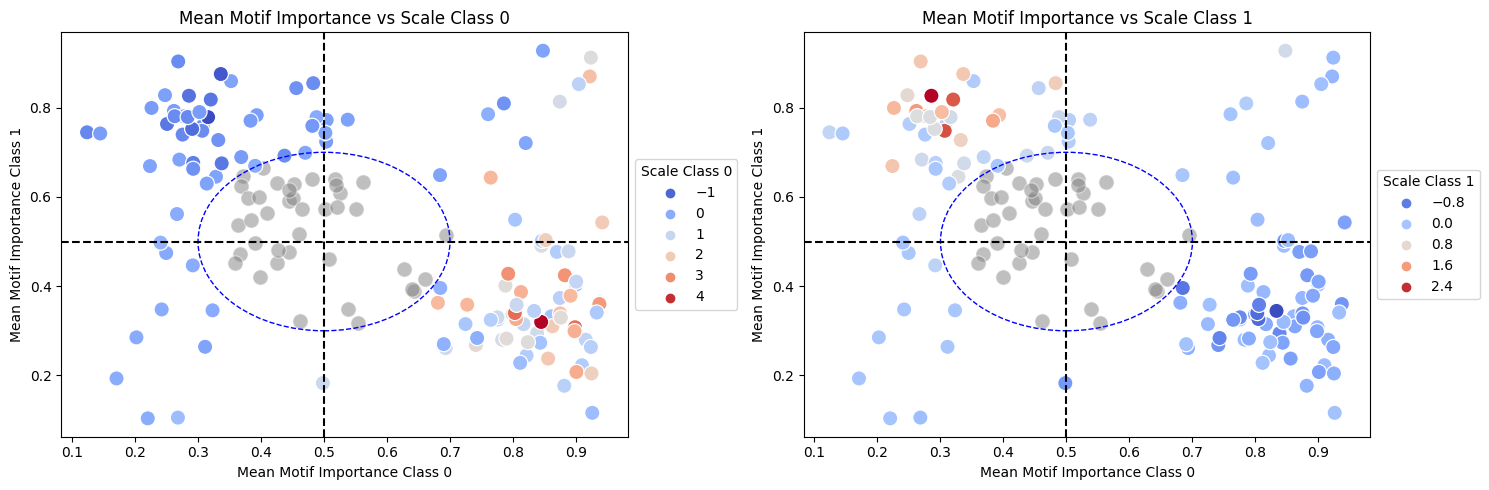

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

palette = sns.color_palette("vlag", as_cmap=True)

sns.scatterplot(data=logit_val, x="mean_sigmoid_importance_class_0", y="mean_sigmoid_importance_class_1", hue = "mean_logit_diff_class_0",ax=axes[0],palette = palette,alpha=1,s=120)
axes[0].set_title('Mean Motif Importance for class vs Mean Logit Difference Class 0')  # Optional title for the seaborn plot
axes[0].set_xlabel('Mean Motif Importance Class 0')  # Optional title for the seaborn plot
axes[0].set_ylabel('Mean Motif Importance Class 1')  # Optional title for the seaborn plot
axes[0].axhline(0.5, color='black', linestyle='--')  # Horizontal line
axes[0].axvline(0.5, color='black', linestyle='--')  # Vertical line
axes[0].legend(title='Mean Logit Difference Class 0', loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

sns.scatterplot(data=logit_val, x="mean_sigmoid_importance_class_0", y="mean_sigmoid_importance_class_1", hue = "mean_logit_diff_class_1",ax=axes[1],palette = palette,alpha=1,s=120)
axes[1].set_title('Mean Motif Importance for class vs Mean Logit Difference Class 1')  # Optional title for the seaborn plot
axes[1].set_xlabel('Mean Motif Importance Class 0')  # Optional title for the seaborn plot
axes[1].set_ylabel('Mean Motif Importance Class 1')  # Optional title for the seaborn plot
axes[1].axhline(0.5, color='black', linestyle='--')  # Horizontal line
axes[1].axvline(0.5, color='black', linestyle='--')  # Vertical line
axes[1].legend(title='Mean Logit Difference Class 1', loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
input()

In [ ]:
'''
model_state = torch.load(EXPT_PATH + f'/explainer/{dataset_dict[dataset]}_1weighted_best_model.pth')
                        model.load_state_dict(model_state)

                        # Convert the tensor to numpy for plotting
                        param_numpy = model.motif_params.sigmoid().cpu().detach().numpy()

                        if channel == 'SingleParam':
                            plot_imp_scores = pd.DataFrame({'Class 0 Importance': 1-param_numpy[:, 0], 'Class 1 Importance': param_numpy[:, 0]})
                        else:
                            plot_imp_scores = pd.DataFrame({'Class 0 Importance': param_numpy[:, 0], 'Class 1 Importance': param_numpy[:, 1]})
'''

In [ ]:
get_motif_quadrants_val = logit_val.groupby('motif_id').apply(lambda x: x[['sigmoid_importance_for_class_1', 'sigmoid_importance_for_class_0']].drop_duplicates()).reset_index()
get_motif_quadrants_val['quadrant'] = get_motif_quadrants_val.apply(lambda x : return_quadrant_of_motif(x['sigmoid_importance_for_class_0'],x['sigmoid_importance_for_class_1']), axis = 1)

get_motif_quadrants_test = logit_test.groupby('motif_id').apply(lambda x: x[['sigmoid_importance_for_class_1', 'sigmoid_importance_for_class_0']].drop_duplicates()).reset_index()
get_motif_quadrants_test['quadrant'] = get_motif_quadrants_test.apply(lambda x : return_quadrant_of_motif(x['sigmoid_importance_for_class_0'],x['sigmoid_importance_for_class_1']), axis = 1)

In [ ]:
#Get sum of motif importances for each graph
mean_motif_importance_per_graph_val  = logit_val.groupby(['batch_id','smile_id']).agg(
                                            mean_graph_importance_1=('sigmoid_importance_for_class_1', 'mean'),
                                            mean_graph_importance_0=('sigmoid_importance_for_class_0', 'mean'),
                                            num_motifs_in_graph    =('motif_id', 'count')).reset_index()

mean_motif_importance_per_graph_test = logit_test.groupby(['batch_id','smile_id']).agg(
                                            mean_graph_importance_1=('sigmoid_importance_for_class_1', 'mean'),
                                            mean_graph_importance_0=('sigmoid_importance_for_class_0', 'mean'),
                                            num_motifs_in_graph    =('motif_id', 'count')).reset_index()

In [ ]:
logit_val = pd.merge(logit_val,mean_motif_importance_per_graph_val, how = 'inner', on = ['batch_id','smile_id'])
logit_val = pd.merge(logit_val,get_motif_quadrants_val[['motif_id','quadrant']], how = 'inner', on = 'motif_id')

logit_test = pd.merge(logit_test,mean_motif_importance_per_graph_test, how = 'inner', on = ['batch_id','smile_id'])
logit_test = pd.merge(logit_test,get_motif_quadrants_test[['motif_id','quadrant']], how = 'inner', on = 'motif_id')

In [ ]:
#validation
logit_val['motif_importance_ratio_class_1'] = logit_val['sigmoid_importance_for_class_1'] / logit_val['mean_graph_importance_1']
logit_val['motif_importance_ratio_class_0'] = logit_val['sigmoid_importance_for_class_0'] / logit_val['mean_graph_importance_0']

logit_val['logit_diff_class_1'] = logit_val['new_logit_class_1'] - logit_val['original_logit_class_1']
logit_val['logit_diff_class_0'] = logit_val['new_logit_class_0'] - logit_val['original_logit_class_0']

#test
logit_test['motif_importance_ratio_class_1'] = logit_test['sigmoid_importance_for_class_1'] / logit_test['mean_graph_importance_1']
logit_test['motif_importance_ratio_class_0'] = logit_test['sigmoid_importance_for_class_0'] / logit_test['mean_graph_importance_0']

logit_test['logit_diff_class_1'] = logit_test['new_logit_class_1'] - logit_test['original_logit_class_1']
logit_test['logit_diff_class_0'] = logit_test['new_logit_class_0'] - logit_test['original_logit_class_0']

In [ ]:

#plotting
fig, axes = plt.subplots(3, 8, figsize=(60,20))

sns.lineplot(data=loss_long, x='Epoch', y='loss', hue='loss_type', marker='o', ax = axes[0,0], alpha=0.8)
# Customize the plot
axes[0,0].set_title('Training and Validation Loss Over Epochs')
axes[0,0].set_xlabel('Epochs')
axes[0,0].set_ylabel('Loss')
axes[0,0].legend(title='Loss Type')
axes[0,0].grid()

sns.lineplot(data=acc_long, x='Epoch', y='auroc', hue='auroc_type', marker='o', ax = axes[0,1], alpha=0.8)
# Customize the plot
axes[0,1].set_title('Training and Validation ROC-AUC Over Epochs')
axes[0,1].set_xlabel('Epochs')
axes[0,1].set_ylabel('ROC-AUC')
axes[0,1].legend(title='ROC-AUC Type')
axes[0,1].grid()



sns.scatterplot(data=plot_imp_scores, x="Class 0 Importance", y="Class 1 Importance",ax=axes[0,2],alpha=0.8,s=120)
axes[0,2].set_title('Motif Important for each class')  # Optional title for the seaborn plot
axes[0,2].axhline(0.5, color='black', linestyle='--')  # Horizontal line
axes[0,2].axvline(0.5, color='black', linestyle='--')  # Vertical line


if channel != 'SingleParam':

    mean = np.mean(param_numpy, axis=0)
    cov_matrix = np.cov(param_numpy.T)  # Use transpose to get the right shape

    if np.linalg.det(cov_matrix) != 0.0:
        # cov_matrix = np.cov(param_numpy.T)
        y_offset = np.random.uniform(-5, 5)
        inv_cov_matrix = np.linalg.inv(cov_matrix)

        mahalanobis_distances = [
            distance.mahalanobis(point, mean, inv_cov_matrix) for point in param_numpy
        ]
        divergent_indices = np.argsort(mahalanobis_distances)[-10:]

        for i in divergent_indices:
            axes[0,2].annotate(motif_list[i], (param_numpy[i, 0], param_numpy[i, 1]), textcoords="offset points", xytext=(5, 5+ y_offset), ha='center',fontsize='large')

axes[0, 3].axis('off')
axes[0, 4].axis('off')
axes[0, 5].axis('off')
axes[0, 6].axis('off')
axes[0, 7].axis('off')


# Row 2: Quadrant Scatter Plots
for i in range(1, 5):  # For quadrants 1 to 4
    
    if i == 1:
        a = 1
        b = 1
    if i == 2:
        a = 1
        b = 0
    if i == 3:
        a = 2
        b = 0
    if i == 4:
        a = 2
        b = 1
        
    # Filter data for the current quadrant
    quadrant_data = logit_val[logit_val['quadrant'] == i]
    
    scatter = sns.scatterplot(x = quadrant_data['motif_importance_ratio_class_1'],y = quadrant_data['logit_diff_class_1'],hue = quadrant_data['sigmoid_importance_for_class_1'],ax=axes[a,b],alpha=0.8,palette='winter', edgecolor='w',s=100)
    #sns.move_legend(scatter, "upper left", bbox_to_anchor=(1, 1))
    axes[a,b].legend(title='Sigmoid Motif Importance', loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
    axes[a,b].axhline(0.0, color='black', linestyle='--')  # Horizontal line
    axes[a,b].set_title(f'Quadrant {i}')
    axes[a,b].set_xlabel('Motif Importance Ratio Class 1')
    axes[a,b].set_ylabel('Logit Difference Class 1 ')
    axes[a,b].grid()
    
    # Scatter
    # Add a common title for the quadrant plots
    fig.text(0.11, 0.63, 'Motif Importance Ratio vs Logit Difference Class 1 Validation', ha='center', va='center', fontsize=12)
    #fig.text(0.25, 0.32, 'Common Title for Plots 8, 9, 10, 11', ha='center', va='center', fontsize=14)
    
    plt.subplots_adjust(bottom=0.2)
    
    
# Row 2: Quadrant Scatter Plots
for i in range(1, 5):  # For quadrants 1 to 4
    
    if i == 1:
        a = 1
        b = 3
    if i == 2:
        a = 1
        b = 2
    if i == 3:
        a = 2
        b = 2
    if i == 4:
        a = 2
        b = 3
        
    # Filter data for the current quadrant
    quadrant_data = logit_val[logit_val['quadrant'] == i]
    
    scatter = sns.scatterplot(x = quadrant_data['motif_importance_ratio_class_0'],y = quadrant_data['logit_diff_class_0'],hue = quadrant_data['sigmoid_importance_for_class_0'],ax=axes[a,b],alpha=0.8,palette='winter', edgecolor='w',s=100)
    #sns.move_legend(scatter, "upper left", bbox_to_anchor=(1, 1))
    axes[a,b].legend(title='Sigmoid Motif Importance', loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
    axes[a,b].axhline(0.0, color='black', linestyle='--')  # Horizontal line
    axes[a,b].set_title(f'Quadrant {i}')
    axes[a,b].set_xlabel('Motif Importance Ratio Class 0')
    axes[a,b].set_ylabel('Logit Difference Class 0')
    axes[a,b].grid()
    
    # Scatter
    # Add a common title for the quadrant plots
    fig.text(0.36, 0.63, 'Motif Importance Ratio vs Logit Difference Class 0 Validation', ha='center', va='center', fontsize=12)
    #fig.text(0.25, 0.32, 'Common Title for Plots 8, 9, 10, 11', ha='center', va='center', fontsize=14)
    
    plt.subplots_adjust(bottom=0.2)
    

# Row 2: Quadrant Scatter Plots
for i in range(1, 5):  # For quadrants 1 to 4
    
    if i == 1:
        a = 1
        b = 5
    if i == 2:
        a = 1
        b = 4
    if i == 3:
        a = 2
        b = 4
    if i == 4:
        a = 2
        b = 5
        
    # Filter data for the current quadrant
    quadrant_data = logit_test[logit_test['quadrant'] == i]
    
    scatter = sns.scatterplot(x = quadrant_data['motif_importance_ratio_class_1'],y = quadrant_data['logit_diff_class_1'],hue = quadrant_data['sigmoid_importance_for_class_1'],ax=axes[a,b],alpha=0.8,palette='winter', edgecolor='w',s=100)
    #sns.move_legend(scatter, "upper left", bbox_to_anchor=(1, 1))
    axes[a,b].legend(title='Sigmoid Motif Importance', loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
    axes[a,b].axhline(0.0, color='black', linestyle='--')  # Horizontal line
    axes[a,b].set_title(f'Quadrant {i}')
    axes[a,b].set_xlabel('Motif Importance Ratio Class 1')
    axes[a,b].set_ylabel('Logit Difference Class 1 ')
    axes[a,b].grid()
    
    # Scatter
    # Add a common title for the quadrant plots
    fig.text(0.61, 0.63, 'Motif Importance Ratio vs Logit Difference Class 1 Test', ha='center', va='center', fontsize=12)
    #fig.text(0.25, 0.32, 'Common Title for Plots 8, 9, 10, 11', ha='center', va='center', fontsize=14)
    
    plt.subplots_adjust(bottom=0.2)
    
    
# Row 2: Quadrant Scatter Plots
for i in range(1, 5):  # For quadrants 1 to 4
    
    if i == 1:
        a = 1
        b = 7
    if i == 2:
        a = 1
        b = 6
    if i == 3:
        a = 2
        b = 6
    if i == 4:
        a = 2
        b = 7
        
    # Filter data for the current quadrant
    quadrant_data = logit_test[logit_test['quadrant'] == i]
    
    scatter = sns.scatterplot(x = quadrant_data['motif_importance_ratio_class_0'],y = quadrant_data['logit_diff_class_0'],hue = quadrant_data['sigmoid_importance_for_class_0'],ax=axes[a,b],alpha=0.8,palette='winter', edgecolor='w',s=100)
    #sns.move_legend(scatter, "upper left", bbox_to_anchor=(1, 1))
    axes[a,b].legend(title='Sigmoid Motif Importance', loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
    axes[a,b].axhline(0.0, color='black', linestyle='--')  # Horizontal line
    axes[a,b].set_title(f'Quadrant {i}')
    axes[a,b].set_xlabel('Motif Importance Ratio Class 0')
    axes[a,b].set_ylabel('Logit Difference Class 0')
    axes[a,b].grid()
    
    # Scatter
    # Add a common title for the quadrant plots
    fig.text(0.86, 0.63, 'Motif Importance Ratio vs Logit Difference Class 0 Test', ha='center', va='center', fontsize=12)
    #fig.text(0.25, 0.32, 'Common Title for Plots 8, 9, 10, 11', ha='center', va='center', fontsize=14)
    
    plt.subplots_adjust(bottom=1.1, top = 1.2)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
result_list = []


for k,v in results_dict.items():
    
    dataset = v['dataset']
    seed = v['seed']
    arch = v['layer_type']
    folder = v['folder']
    size_reg = v['size_reg']
    channel = ''#v['model_type']
    
    if size_reg == 0.0:
        size_reg = 0
    
    training_data = MolDataset(root=".", split='training',csv_file=f"{dataset_dict[dataset]}.csv")
    with open(f'./dictionary/{dataset_dict[dataset]}_graph_lookup_{date_tag}.pickle', 'rb') as file:
        lookup = pickle.load(file)
    with open(f'dictionary/{dataset_dict[dataset]}_motif_list_{date_tag}.pickle', 'rb') as file:
        motif_list = list(pickle.load(file))
    with open(f'dictionary/{dataset_dict[dataset]}_test_graph_lookup_{date_tag}.pickle', 'rb') as file:
        # Serialize and save the object to the file
        test_data_lookup = pickle.load(file)
    
    if channel == 'SingleParam':
        params_motif_x_class = torch.full((len(motif_list), 1), 0.0)
    else:
        params_motif_x_class = torch.full((len(motif_list), 2), 0.0)
    
                    
    found = True
    #get folder name
    EXPT_NAME = return_expt_base_name(seed,arch,size_reg,dataset)
    # EXPT_NAME = return_expt_base_name(seed,arch,channel,dataset)

    #check if EXPT_NAME exists in folder
    EXPT_LOCATION = base_path+f'/{folder}/{EXPT_NAME}'
    
    
    
    if os.path.exists(EXPT_LOCATION):

        #TRY loading the json file
        try:
            with open(EXPT_LOCATION+f'/{dataset_dict[dataset]}config.json') as file:
                config = json.load(file)
        except Exception as e:
            print(f"error when trying to load config Json : {e}")
            found = False

        try:
            
            
            #Recreate loss metrics
            try:
                train_metrics = pd.read_csv(EXPT_LOCATION+f'/explainer/{dataset_dict[dataset]}.csv')
            except Exception as e:
                print(f"error when trying to load train metrics: {e}")
                found = False
            
            train_metrics['Train Loss'] = train_metrics['Train Loss'] - train_metrics['Mask Loss']
            
            
            loss_long = pd.melt(train_metrics, id_vars='Epoch', value_vars=['Train Loss', 'Val Loss'],var_name='loss_type', value_name='loss')
            acc_long = pd.melt(train_metrics, id_vars='Epoch', value_vars=['Train ROC-AUC', 'Val ROC-AUC'],var_name='auroc_type', value_name='auroc')
            
            
            imp_vs_logit_diff_val = pd.read_csv(EXPT_LOCATION+f'/{dataset_dict[dataset]}_explanation_result_with_validation.csv')
                        
            imp_vs_logit_diff_val['logit_diff_class_1'] = imp_vs_logit_diff_val['new_logit_class_1'] - imp_vs_logit_diff_val['original_logit_class_1']
            imp_vs_logit_diff_val['logit_diff_class_0'] = imp_vs_logit_diff_val['new_logit_class_0'] - imp_vs_logit_diff_val['original_logit_class_0']
            imp_vs_logit_diff_val['sigmoid_importance_for_class_1_temp'] = imp_vs_logit_diff_val['sigmoid_importance_for_class_1']-imp_vs_logit_diff_val['sigmoid_importance_for_class_0']
            imp_vs_logit_diff_val['sigmoid_importance_for_class_0'] = imp_vs_logit_diff_val['sigmoid_importance_for_class_0']-imp_vs_logit_diff_val['sigmoid_importance_for_class_1']
            imp_vs_logit_diff_val['sigmoid_importance_for_class_1'] = imp_vs_logit_diff_val['sigmoid_importance_for_class_1_temp']
            imp_vs_logit_diff_val.drop('sigmoid_importance_for_class_1_temp', axis=1, inplace = True)
            
            if channel == 'SingleParam':
                imp_vs_logit_diff_val['sigmoid_importance_for_class_1'] = imp_vs_logit_diff_val['sigmoid_importance_for_class_0']
                imp_vs_logit_diff_val['sigmoid_importance_for_class_0'] = 1-imp_vs_logit_diff_val['sigmoid_importance_for_class_1']
            
            imp_vs_logit_diff_val = imp_vs_logit_diff_val.groupby('motif_id').agg(
                                            Mean_Logit_Difference_Class_1=('logit_diff_class_1', 'mean'),
                                            Mean_Logit_Difference_Class_0=('logit_diff_class_0', 'mean'),
                                            Mean_Motif_Importance_Class_1=('sigmoid_importance_for_class_1', 'mean'),
                                            Mean_Motif_Importance_Class_0=('sigmoid_importance_for_class_0', 'mean'),
                                            Count_of_Graphs_where_Motif_Found=('motif_id', 'count')
                                        ).reset_index()
            
            imp_vs_logit_diff_val = imp_vs_logit_diff_val.rename(columns = {'Mean_Logit_Difference_Class_1' : 'Mean Logit Difference Class 1',
                                                                    'Mean_Logit_Difference_Class_0' : 'Mean Logit Difference Class 0',
                                                                    'Mean_Motif_Importance_Class_1':'Mean Motif Importance Class 1',
                                                                    'Mean_Motif_Importance_Class_0':'Mean Motif Importance Class 0',
                                                                    'Count_of_Graphs_where_Motif_Found':'Count of Graphs where Motif Found'})
            
            imp_vs_logit_diff_test = pd.read_csv(EXPT_LOCATION+f'/{dataset_dict[dataset]}_explanation_result_with_test.csv')
            imp_vs_logit_diff_test['logit_diff_class_1'] = imp_vs_logit_diff_test['new_logit_class_1'] - imp_vs_logit_diff_test['original_logit_class_1']
            imp_vs_logit_diff_test['logit_diff_class_0'] = imp_vs_logit_diff_test['new_logit_class_0'] - imp_vs_logit_diff_test['original_logit_class_0']
            
            if channel == 'SingleParam':
                imp_vs_logit_diff_test['sigmoid_importance_for_class_1'] = imp_vs_logit_diff_test['sigmoid_importance_for_class_0']
                imp_vs_logit_diff_test['sigmoid_importance_for_class_0'] = 1-imp_vs_logit_diff_test['sigmoid_importance_for_class_1']
            
            imp_vs_logit_diff_test = imp_vs_logit_diff_test.groupby('motif_id').agg(
                                            Mean_Logit_Difference_Class_1=('logit_diff_class_1', 'mean'),
                                            Mean_Logit_Difference_Class_0=('logit_diff_class_0', 'mean'),
                                            Mean_Motif_Importance_Class_1=('sigmoid_importance_for_class_1', 'mean'),
                                            Mean_Motif_Importance_Class_0=('sigmoid_importance_for_class_0', 'mean'),
                                            Count_of_Graphs_where_Motif_Found=('motif_id', 'count')
                                        ).reset_index()
            
            imp_vs_logit_diff_test = imp_vs_logit_diff_test.rename(columns = {'Mean_Logit_Difference_Class_1' : 'Mean Logit Difference Class 1',
                                                                    'Mean_Logit_Difference_Class_0' : 'Mean Logit Difference Class 0',
                                                                    'Mean_Motif_Importance_Class_1':'Mean Motif Importance Class 1',
                                                                    'Mean_Motif_Importance_Class_0':'Mean Motif Importance Class 0',
                                                                    'Count_of_Graphs_where_Motif_Found':'Count of Graphs where Motif Found'})
            
            
            model = GNNModel(input_dim = training_data.num_features, 
                             hidden_channels = config["hidden"], 
                             output_dim = training_data.num_classes, 
                             num_layers = config["num_mp_layers"],
                             use_explainer=True,
                             motif_params = params_motif_x_class,
                             lookup = lookup,
                             layer_type = config["layer_type"],
                             test_lookup = test_data_lookup)

            model.to(device)
            model_state = torch.load(EXPT_LOCATION + f'/explainer/{dataset_dict[dataset]}_1weighted_best_model.pth')
            model.load_state_dict(model_state)

            # Convert the tensor to numpy for plotting
            param_numpy = model.motif_params.sigmoid().cpu().detach().numpy()
            
            if channel == 'SingleParam':
                plot_imp_scores = pd.DataFrame({'Class 0 Importance': 1-param_numpy[:, 0], 'Class 1 Importance': param_numpy[:, 0]})
            else:
                plot_imp_scores = pd.DataFrame({'Class 0 Importance': param_numpy[:, 0], 'Class 1 Importance': param_numpy[:, 1]})
            #plot_imp_scores['Class 0 Importance'] = plot_imp_scores['Class 0 Importance'].apply(lambda x: 1/(1 + np.exp(-x)))
            #plot_imp_scores['Class 1 Importance'] = plot_imp_scores['Class 1 Importance'].apply(lambda x: 1/(1 + np.exp(-x)))
            
            
            #imp_plot.set_title('Motif Class Importance')
            #plt.show()

        except Exception as e:
            print(f"error when trying to load model : {e}")
            found = False

        fig, axes = plt.subplots(2, 4, figsize=(40,10))

        # Display the images
        sns.lineplot(data=loss_long, x='Epoch', y='loss', hue='loss_type', marker='o', ax = axes[0,0], alpha=0.8)
        # Customize the plot
        axes[0,0].set_title('Training and Validation Loss Over Epochs')
        axes[0,0].set_xlabel('Epochs')
        axes[0,0].set_ylabel('Loss')
        axes[0,0].legend(title='Loss Type')
        axes[0,0].grid()
                            
        sns.lineplot(data=acc_long, x='Epoch', y='auroc', hue='auroc_type', marker='o', ax = axes[0,1], alpha=0.8)
        # Customize the plot
        axes[0,1].set_title('Training and Validation ROC-AUC Over Epochs')
        axes[0,1].set_xlabel('Epochs')
        axes[0,1].set_ylabel('ROC-AUC')
        axes[0,1].legend(title='ROC-AUC Type')
        axes[0,1].grid()

        
    
        sns.scatterplot(data=plot_imp_scores, x="Class 0 Importance", y="Class 1 Importance",ax=axes[0,2],alpha=0.8,s=120)
        axes[0,2].set_title('Motif Important for each class')  # Optional title for the seaborn plot
        axes[0,2].axhline(0.5, color='black', linestyle='--')  # Horizontal line
        axes[0,2].axvline(0.5, color='black', linestyle='--')  # Vertical line
        
        
        if channel != 'SingleParam':
            
            mean = np.mean(param_numpy, axis=0)
            cov_matrix = np.cov(param_numpy.T)  # Use transpose to get the right shape
        
            if np.linalg.det(cov_matrix) != 0.0:
                # cov_matrix = np.cov(param_numpy.T)
                y_offset = np.random.uniform(-5, 5)
                inv_cov_matrix = np.linalg.inv(cov_matrix)

                mahalanobis_distances = [
                    distance.mahalanobis(point, mean, inv_cov_matrix) for point in param_numpy
                ]
                divergent_indices = np.argsort(mahalanobis_distances)[-10:]

                for i in divergent_indices:
                    axes[0,2].annotate(motif_list[i], (param_numpy[i, 0], param_numpy[i, 1]), textcoords="offset points", xytext=(5, 5+ y_offset), ha='center',fontsize='large')

        axes[0, 3].axis('off')
        
        scatter_0 = sns.scatterplot(data=imp_vs_logit_diff_val, x="Mean Motif Importance Class 1", y="Mean Logit Difference Class 1",size='Count of Graphs where Motif Found',sizes=(100, 700),ax=axes[1,0], alpha=0.8)
        handles, labels = scatter_0.get_legend_handles_labels()
        axes[1,0].legend(handles, labels, loc='center left', ncol=1, bbox_to_anchor=(1.0, 0.5))
        axes[1,0].set_title('Motif Importance vs Logit Difference for Class 1 in Validation')  # Optional title for the seaborn plot
        axes[1,0].axhline(0, color='black', linestyle='--')  # Horizontal line
        axes[1,0].axvline(0, color='black', linestyle='--')  # Vertical line
        
        
        scatter_1 = sns.scatterplot(data=imp_vs_logit_diff_val, x="Mean Motif Importance Class 0", y="Mean Logit Difference Class 0",size='Count of Graphs where Motif Found',sizes=(100, 700),alpha=0.8,ax=axes[1,1])
        handles, labels = scatter_1.get_legend_handles_labels()
        axes[1,1].legend(handles, labels, loc='center left', ncol=1, bbox_to_anchor=(1.0, 0.5))
        axes[1,1].set_title('Motif Importance vs Logit Difference for Class 0 in Validation')  # Optional title for the seaborn plot
        axes[1,1].axhline(0, color='black', linestyle='--')  # Horizontal line
        axes[1,1].axvline(0, color='black', linestyle='--')  # Vertical line
        
        scatter_2 = sns.scatterplot(data=imp_vs_logit_diff_test, x="Mean Motif Importance Class 1", y="Mean Logit Difference Class 1",size='Count of Graphs where Motif Found',sizes=(100, 700),alpha=0.8,ax=axes[1,2])
        handles, labels = scatter_2.get_legend_handles_labels()
        axes[1,2].legend(handles, labels, loc='center left', ncol=1, bbox_to_anchor=(1.0, 0.5))
        axes[1,2].set_title('Motif Importance vs Logit Difference for Class 1 in Test')  # Optional title for the seaborn plot
        axes[1,2].axhline(0, color='black', linestyle='--')  # Horizontal line
        axes[1,2].axvline(0, color='black', linestyle='--')  # Vertical line
        
        
        scatter_3 = sns.scatterplot(data=imp_vs_logit_diff_test, x="Mean Motif Importance Class 0", y="Mean Logit Difference Class 0",size='Count of Graphs where Motif Found',sizes=(100, 700),alpha=0.8,ax=axes[1,3])
        handles, labels = scatter_3.get_legend_handles_labels()
        axes[1,3].legend(handles, labels, loc='center left', ncol=1, bbox_to_anchor=(1.0, 0.5))
        axes[1,3].set_title('Motif Importance vs Logit Difference for Class 0 in Test')  # Optional title for the seaborn plot
        axes[1,3].axhline(0, color='black', linestyle='--')  # Horizontal line
        axes[1,3].axvline(0, color='black', linestyle='--')  # Vertical line
        
        fig.suptitle(f'{dataset_dict[dataset]} - {arch} - Seed : {seed} - Channel {channel} - Size Reg {size_reg} - LR {config["lr"]} - Message Passing : {config["num_mp_layers"]} - Hidden : {config["hidden"]} - Entropy Reg : {config["ent_reg"]}', fontsize=16)
        
        plt.tight_layout()
    
    else:
        print(f'Expt does not exist at Path : {EXPT_LOCATION}')
        found = False  

    if found:
        if not os.path.exists(PLOT_LOCATION):
            fig.savefig(PLOT_LOCATION, bbox_inches='tight')
        else:
            fig.savefig("temp.pdf", bbox_inches='tight')

            plt.close(fig)

            with open(PLOT_LOCATION, 'rb') as existing_file, open('temp.pdf', 'rb') as temp_file:
                existing_pdf = PdfReader(existing_file)
                temp_pdf = PdfReader(temp_file)

                # Create a writer object
                pdf_writer = PdfWriter()

                # Add all pages from the existing PDF
                for page in existing_pdf.pages:
                    pdf_writer.add_page(page)

                # Add all pages from the new PDF (temp.pdf)
                for page in temp_pdf.pages:
                    pdf_writer.add_page(page)

                # Save the updated PDF back to all_plots.pdf
                with open(PLOT_LOCATION, 'wb') as output_file:
                    pdf_writer.write(output_file)

            os.remove('temp.pdf')
            
            print(f'Finished : {dataset_dict[dataset]} - {arch} - Seed : {seed} - Channel {channel} - Size Reg {size_reg} - LR {config["lr"]} - Message Passing : {config["num_mp_layers"]} - Hidden : {config["hidden"]} - Entropy Reg : {config["ent_reg"]}')

        #Try loading the model for importance scores
    else:
        print(f'Expt does not exist at Path : {EXPT_LOCATION}')
        found = False

In [ ]:
'''

1. Thresholding radious 0.1,0.2

2. Measure y=x

y=x -> motif is close. SHared motifs between channels. M>Thresh Q1 Class 1 +ve logit, Class 0 -ve (A) .. Q1 and Q3 +ve Class 1 Q1 and Q3 ive Class 0 (B)

y=1-x -> motif is close class discriminatory. Q2 +ve Q4 -ve Class 1 Q2 -ve Q4 +ve for class 0

'''

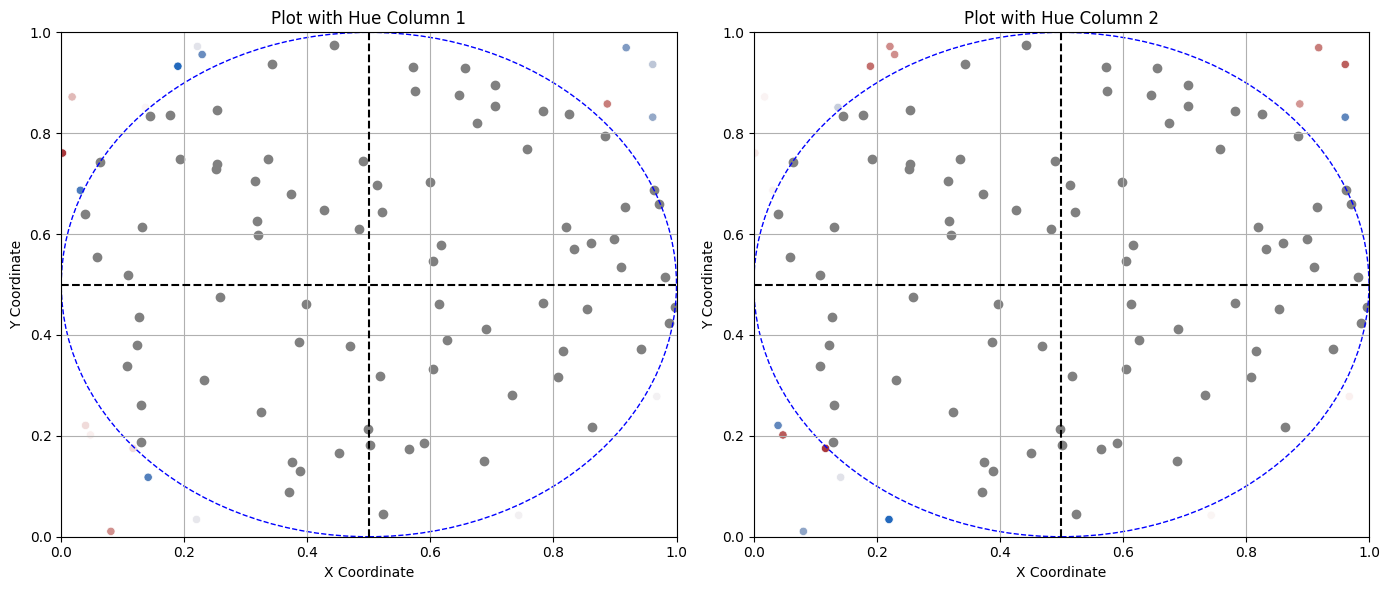

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sample DataFrame
data = {
    'col_x': np.random.rand(100),  # Random x-coordinates
    'col_y': np.random.rand(100),  # Random y-coordinates
    'hue_col_1': np.random.rand(100),  # Random values for first hue
    'hue_col_2': np.random.rand(100)   # Random values for second hue
}

df = pd.DataFrame(data)

# Center and radius of the circle
center_x, center_y = 0.5, 0.5
radius = 0.5

# Calculate distances from the center
df['distance'] = np.sqrt((df['col_x'] - center_x) ** 2 + (df['col_y'] - center_y) ** 2)

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Function to plot data
def plot_data(ax, hue_col, title):
    # Points inside the circle
    inside_circle = df[df['distance'] <= radius]
    ax.scatter(inside_circle['col_x'], inside_circle['col_y'], color='grey', label='Inside Circle')

    # Points outside the circle
    outside_circle = df[df['distance'] > radius]
    sns.scatterplot(data=outside_circle, x='col_x', y='col_y', hue=hue_col, palette='vlag', ax=ax, legend=False)

    # Adding horizontal and vertical lines at 0.5
    ax.axhline(0.5, color='black', linestyle='--')
    ax.axvline(0.5, color='black', linestyle='--')

    # Adding a circle for visualization
    circle = plt.Circle((center_x, center_y), radius, color='blue', fill=False, linestyle='--')
    ax.add_artist(circle)

    # Set limits and labels
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(title)
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.grid(True)

# Plot for hue_col_1
plot_data(axes[0], 'hue_col_1', 'Plot with Hue Column 1')

# Plot for hue_col_2
plot_data(axes[1], 'hue_col_2', 'Plot with Hue Column 2')

plt.tight_layout()
plt.show()
